## Pre-Processing

The first step for any machine learning classification problem is to preprocess the data avilable for the training process.

In this project, we worked with images of craters on Mars surface. These images needed to be standarized to feed into a neural network.

We decided to try both of the suggested methods to see their differences:
- Adding padding to images smaller than 200x200 (with black background)
- Rescale all the images to 200x200

All of the data was preprocessed, including positive and negative samples.

We found the rescaling method (MINMAX) yields better results.

In [1]:
import cv2
import glob
import os

src = 'crater_data/images/tile3_24'
dsta = 'crater_data/images/normalized_images_padded'
dstb = 'crater_data/images/normalized_images_scaled'

# create new directories if necessary
for dst in [dsta, dstb]:
    for imgtype in ['crater', 'non-crater']:
        tgdir = os.path.join(dst, imgtype)
        if not os.path.isdir(tgdir):
            os.makedirs(tgdir)

BGCOLOR = [0, 0, 0]
for src_filename in glob.glob(src + '/*/*.jpg'):
    pathinfo = src_filename.split('/')
    img_type = pathinfo[-2] # crater or non-crater
    filename = pathinfo[-1] # the actual name of the jpg
    
    dsta_filename = os.path.join(dsta, img_type, filename)
    dstb_filename = os.path.join(dstb, img_type, filename)

    # read the original image and get size info
    src_img = cv2.imread(src_filename)
    height, width = src_img.shape[:2]
    
    # get size of the padding, apply padding and write to disk
    brd = int((200 - height) / 2)
    padded_img = cv2.copyMakeBorder(src_img, brd, brd, brd, brd,
                                    cv2.BORDER_CONSTANT, value=BGCOLOR)
    cv2.imwrite(dsta_filename, padded_img)
    
    # resize image, normalize and write to disk
    scaled_img = cv2.resize(src_img, (200, 200))
    cv2.normalize(scaled_img, scaled_img, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(dstb_filename, scaled_img)

## Crater-loader

We observed that the learning process of the neural network is more stable if we renormalize the pixel values to be between 0 and 1.

In [2]:
import cv2 
import glob
import random 

def load_crater_data_wrapper(method='scaled'):
    
    # set origin path for the images
    src = 'crater_data/images/normalized_images_' + method
    
    # this dict helps to create binary labels for the pictures
    labels_dict = {'crater': 1, 'non-crater': 0}
    
    samples = []
    # get all images file paths
    for src_filename in glob.glob(src + '/*/*.jpg'):
        # extract info from file path
        pathinfo = src_filename.split('/')
        img_type = pathinfo[-2] # crater or non-crater
        filename = pathinfo[-1] # the actual name of the jpg
        
        # read the grayscale version of the image, 
        # and normalize its values to be between 0 and 1
        img = cv2.imread(src_filename, cv2.IMREAD_GRAYSCALE) / 255.0
        
        # reshape the data structure to be a 1-D column vector
        img = img.flatten().reshape((len(img)**2, 1))
        
        # include the image data and its label into the sample list
        samples.append((img, labels_dict[img_type]))
    
    # We have to shuffle the order before splitting between training data
    # and test data
    random.shuffle(samples)
    
    # determine slices for training and test data
    splitpos = int(len(samples) * 0.7)
    return samples[:splitpos], samples[splitpos:]
    

## Crater Network1

#### Description:
We modified the network.py code to apply for this project.

- Adjust evaluation function: This was neccesary due to the output type of the developed network. Additionally, this method now returns the detection, false and quality rates, along with the confussion matrix for the provided test data.
- Customizable threshold
- Store network evaluation results in each epoch, as an attribute of the class

We added a function, learning_rate(epoch, $\eta$), in the network to install scheduled (decaying) learning rate. With the large learning rate, the gradient descent has fast approaches toward the minimum but high risk of oscillation. Whereas, with the small learning rate, the gradient descent has low risk of oscilation but the slow approaches toward the minimum. This decaying learning rate can take advanatages from both large and small learning rates.


In [3]:
import random
import numpy as np

class Network(object):

    def __init__(self, sizes, printoutput=True):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
        # some extra attributes that customize our network
        self.threshold = 0.5 # activation threshold can be changed
        self.epoch = 0       # keeps track of the total epochs of training
        self.history = []    # stores test evaluation after each epoch
        self.printoutput = printoutput 

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            self.epoch += 1
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                # get test results after this epoch
                rs = self.evaluate(test_data)
                tp, fp, fn = rs[0], rs[1], rs[2]
                det, fal, qua = rs[3], rs[4], rs[5]
                acc = rs[6]
                
                # store test results on the history tracker
                epochdata = (self.epoch, tp, fp, fn, det, fal, qua, acc)
                self.history.append(epochdata)
                
                if self.printoutput:
                    print (("Epoch % 5d: % 7d % 7d % 7d "
                            "% 5.4f % 5.4f % 5.4f % 14.4f") % epochdata)
            elif self.printoutput:
                print "Epoch {0} complete".format(self.epoch)

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        th = self.threshold
        test_results = [(int(self.feedforward(x)[0][0] > th), y)
                        for (x, y) in test_data]
        
        # the confusion matrix
        #       TN  FN
        #       FP  TP
        cm = [[0, 0],[0, 0]] 
        for x, y in test_results:
            cm[x][y] += 1
        
        tn, fn = cm[0][0], cm[0][1]
        fp, tp = cm[1][0], cm[1][1]

        try:
            det_r = float(tp) / ( tp + fn )
        except ZeroDivisionError:
            det_r = 0.0
        try:
            fal_r = float(fp) / ( tp + fp )
        except ZeroDivisionError:
            fal_r = 1.0
        try:
            qua_r = float(tp) / ( tp + fp + fn )
        except ZeroDivisionError:
            qua_r = 0.0
        
        acc = float(tp + tn) / len(test_results)
        
        return tp, fp, fn, det_r, fal_r, qua_r, acc

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


## Run Experiment 

In [ ]:
import time
from datetime import timedelta
from crater_loader import load_crater_data_wrapper
from crater_network import Network
import numpy as np
import matplotlib.pyplot as plt

iteration = 0
experiment_data = []
for _ in range(3):
    iteration += 1

    start = time.time()
    
    # load the training and test data
    tr_d, te_d = load_crater_data_wrapper()
    
    # define the network shape to be used and the activation threshold
    model = Network([40000, 8, 1], False)
    model.threshold = 0.3

    # the schedule is how the learning rate will be
    # changed during the training
    epochs = 100
    schedule = [(0.1)*(0.5)**np.floor(float(i)/(30)) for i in range(epochs)]
    for eta in schedule:
        # the total epochs is given by the schedule loop
        # we chose minibatch size to be 3
        model.SGD(tr_d, 1, 3, eta, te_d)

    end = time.time()

    # After training is complete, store this model training history
    # to the experiment data
    experiment_data.append(np.array(model.history))
    
    # store current results data to disk
    np.save("experiment_data", experiment_data)
    
    elapsed_time = end - start
    print iteration, timedelta(elapsed_time)


## PLOTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# data numpy array
# axis0: iterations, axis1: epochs, axis2: measurement
data = np.load("experiment_data.npy")

# extract temporal axis
epoch = data[ : , : , 0].mean(axis=0)

# list to store statistics for measurements
stats = []
# helper dictionary
stats_attr = {0: "TP", 1: "FP",  2: "FN",  3: "Detection rate",
              4: "False rate", 5: "Quality rate", 6: "Accuracy"}

for i in range(7):
    # a list for each measurement
    stats.append([])
    # compute statistics along iterations axis
    stats[i].append(data[ : , : , i+1].mean(axis=0))
    stats[i].append(data[ : , : , i+1].std(axis=0))
    stats[i].append(data[ : , : , i+1].min(axis=0))
    stats[i].append(data[ : , : , i+1].max(axis=0))

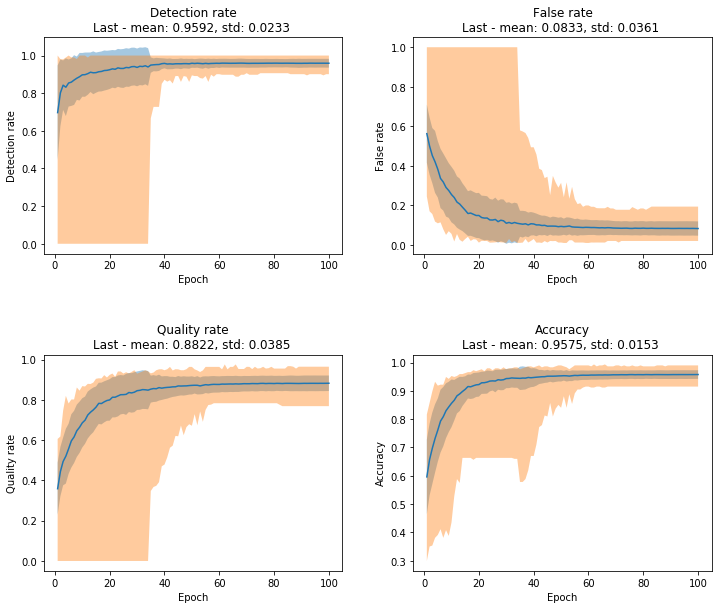

In [3]:
# finally plot statistics of evolution of our Network performance
plotstats = [3, 4, 5, 6]
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.tight_layout(h_pad=8, w_pad=4)
for k, ax in enumerate(axarr.flatten()):
    i = plotstats[k]
    ax.set_xlabel("Epoch")
    ax.set_ylabel(stats_attr[i])
    ax.plot(epoch, stats[i][0])
    ax.set_title("%s\nLast - mean: %.4f, std: %.4f "
              % (stats_attr[i], stats[i][0][-1], stats[i][1][-1]))
    ax.fill_between(epoch, stats[i][0] - stats[i][1],
                    stats[i][0] + stats[i][1], alpha=0.4)
    ax.fill_between(epoch, stats[i][2], stats[i][3], alpha=0.4)

plt.show()

## DISCUSSION 

#### The number of neurons in hidden layers: 
We fixed the numer of the neurons in the hidden layer to 8. With more than 8 neurons, almost the same accuracy with 8 neurons was obtained but computation time became relatively long. With less than 8 neurons, the accuracy decreased a lot.

#### Mini batch size:
3 gave us the optimal results. The convergence has high fluctuations with the larger value of mini batch size.

#### Threshold:
To enforce to obtain a certain level of True Positive rate, we shifted the threshold from $0.5$ to $0.3$. This improved the detection, false and quality rates in the first couple of epochs. However, this does not affect the final detection, false and quality rates.

#### Detection Rate and Misclassification:
Mean detection, false and quality rates for padding and rescaling methods did not have a significant difference. Differences between the means for both methods are less than 5 percents. However, we found the difference in the characteristic of misclassified images. With the network trained by padded images, some crater images, which human can easily recognize as craters, were determined as non-crater. However, every misclassified crater images by the network trained by rescaled images looks as if they were non-crater even with human perceptions.

One of the reasons for the misclassification of the network trained by rescaled images would be the resolution of the original data. Since the crater sizes were too small, expanded images lost their original shapes so that it was too hard for AI and us to correctoly determine their label.

In [ ]:
import time
from datetime import timedelta
from crater_loader import load_crater_data_wrapper
from crater_network import Network
import numpy as np
import matplotlib.pyplot as plt

wrongpred = []
for _ in range(3):
    # load the training and test data
    tr_d, te_d = load_crater_data_wrapper()

    # define the network shape to be used and the activation threshold
    model = Network([40000, 8, 1], False)
    model.threshold = 0.3

    # the schedule is how the learning rate will be
    # changed during the training
    epochs = 100
    schedule = [(0.1)*(0.5)**np.floor(float(i)/(30)) for i in range(epochs)]
    for eta in schedule:
        # the total epochs is given by the schedule loop
        # we chose minibatch size to be 3
        model.SGD(tr_d, 1, 3, eta, te_d)

    for i, sample in enumerate(te_d):
        pred, y = int(model.feedforward(sample[0])[0][0]>model.threshold), sample[1]
        if not pred == y:
            wrongpred.append(sample)


In [ ]:
wrongset = set()
for wp in wrongpred:
    wrongset.add((tuple(list((wp[0]*255).T.astype(np.int)[0])), wp[1]))

missclassified = list(wrongset)

def show_sample(data):
    img = np.array(data[0]).reshape((200,200))
    plt.title("label: %d" % data[1])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()

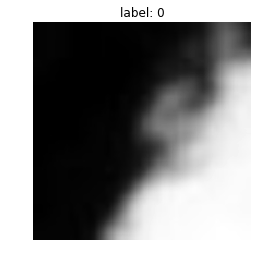

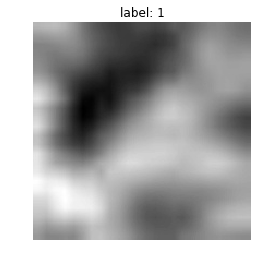

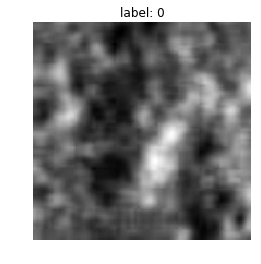

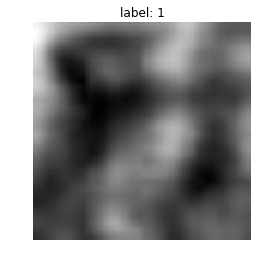

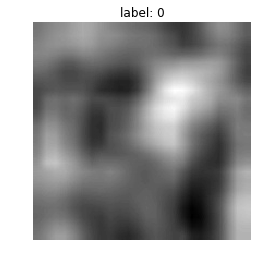

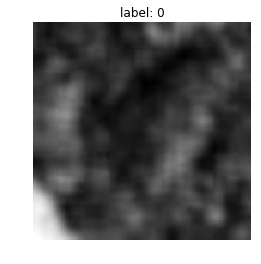

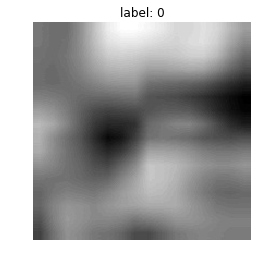

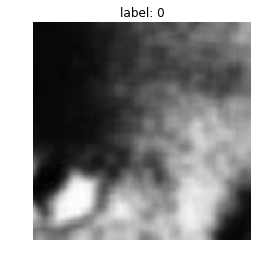

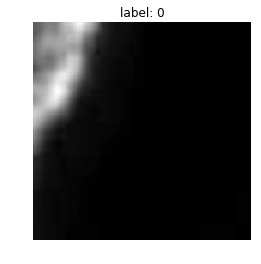

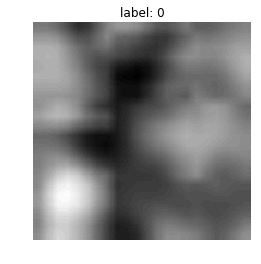

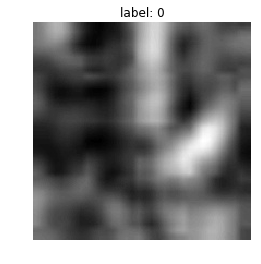

In [3]:
for sample in missclassified:
    show_sample(sample)